# RO47019: Intelligent Control Systems Practical Assignment
* Period: 2022-2023, Q3
* Course homepage: https://brightspace.tudelft.nl/d2l/home/500969
* Instructor: Cosimo Della Santina (C.DellaSantina@tudelft.nl)
* Teaching assistant: Ruben Martin Rodriguez (R.MartinRodriguez@student.tudelft.nl)
* (c) TU Delft, 2023

Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`. Remove `raise NotImplementedError()` afterwards. Moreover, if you see an empty cell, please DO NOT delete it, instead run that cell as you would run all other cells. Please fill in your name(s) and other required details below:

In [1]:
# Please fill in your names, student numbers, netID, and emails below.
STUDENT_1_NAME = "Jesper Ekstrøm"
STUDENT_1_STUDENT_NUMBER = "5900468"
STUDENT_1_NETID = "jekstrom"
STUDENT_1_EMAIL = "J.Ekstrom@student.tudelft.nl"

In [2]:
# Note: this block is a check that you have filled in the above information.
# It will throw an AssertionError until all fields are filled
assert STUDENT_1_NAME != ""
assert STUDENT_1_STUDENT_NUMBER != ""
assert STUDENT_1_NETID != ""
assert STUDENT_1_EMAIL != ""

### General announcements

* Do *not* share your solutions, and do *not* copy solutions from others. By submitting your solutions, you claim that you alone are responsible for this code.

* Do *not* email questions directly, since we want to provide everybody with the same information and avoid repeating the same answers. Instead, please post your questions regarding this assignment in the correct support forum on Brightspace, this way everybody can benefit from the response. If you do have a particular question that you want to ask directly, please use the scheduled Q&A hours to ask the TA.

* There is a strict deadline for each assignment. Students are responsible to ensure that they have uploaded their work in time. So, please double check that your upload succeeded to the Brightspace and avoid any late penalties.

* This [Jupyter notebook](https://jupyter.org/) uses `nbgrader` to help us with automated tests. `nbgrader` will make various cells in this notebook "uneditable" or "unremovable" and gives them a special id in the cell metadata. This way, when we run our checks, the system will check the existence of the cell ids and verify the number of points and which checks must be run. While there are ways that you can edit the metadata and work around the restrictions to delete or modify these special cells, you should not do that since then our nbgrader backend will not be able to parse your notebook and give you points for the assignment. You are free to add additional cells, but if you find a cell that you cannot modify or remove, please know that this is on purpose.

* This notebook will have in various places a line that throws a `NotImplementedError` exception. These are locations where the assignment requires you to adapt the code! These lines are just there as a reminder for youthat you have not yet adapted that particular piece of code, especially when you execute all the cells. Once your solution code replaced these lines, it should accordingly *not* throw any exceptions anymore.

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

# SNN warm-up

We will build a toy example in this section, aiming to generally master how to build a spiking neuron model, a simple network structure, and how the spikes propagate. Several frameworks exist to implement a spiking neural network (SNN), like `PySNN` or `SpikingJelly`. We adopt `snnTorch` in this practical assignment.

snnTorch is a popular Python package to provide a well-embedded gradient-based learning framework for implementing SNNs. It extends the capabilities of PyTorch and could utilize GPU for tensor computation like the traditional neural networks. In addition, it also provides some currently popular neuron models, such as the LIF model. Fundamental neuron dynamics such as leakage have been encapsulated, and we can use them directly.

## Preparation

Here are some preparation methods.

In [3]:
import snntorch as snn
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from snntorch import spikeplot as splt
from snntorch import surrogate
import random

# Some utils methods

from matplotlib.ticker import MultipleLocator


# plot the membrane potential
def print_mem(mem_record, title):
    x_major_locator = MultipleLocator(1)
    plt.figure(figsize=(10, 3))
    plt.title(title)
    mem_record = np.array(mem_record)
    plt.plot(mem_record)
    plt.xlabel("Time Step")
    plt.ylabel("Membrane Potential")
    plt.xlim([0, 20])
    plt.ylim([0, 1])
    plt.gca().xaxis.set_major_locator(x_major_locator)
    plt.grid()
    plt.show()


def print_spk(spk, title):
    x_major_locator = MultipleLocator(1)
    plt.figure(figsize=(10, 0.8))
    plt.title(title)
    splt.raster(spk, plt, s=400, c="black", marker="|")
    plt.yticks([])
    plt.xlim([0, spk.size()[0]])
    plt.gca().xaxis.set_major_locator(x_major_locator)
    plt.show()


def print_spk_mem(mem_record, spk_record, stimulus, threshold, title):
    fig, ax = plt.subplots(
        3, figsize=(10, 6), sharex=True, gridspec_kw={"height_ratios": [0.2, 1, 0.2]}
    )
    x_major_locator = MultipleLocator(1)

    ax[0].set_title(title)
    splt.raster(spk_record, ax[0], s=400, c="black", marker="|")
    ax[0].set_yticks([])
    ax[0].set_ylabel("Output spike")

    ax[1].plot(mem_record)
    ax[1].set_ylim([0, 1])
    ax[1].set_ylabel("Membrane potential")
    ax[1].axhline(threshold, color="r", linestyle="--")
    ax[1].grid()

    splt.raster(stimulus, ax[2], s=400, c="black", marker="|")
    ax[2].set_yticks([])
    ax[2].set_ylabel("Input stimulus")

    plt.xlim([0, 20])
    plt.gca().xaxis.set_major_locator(x_major_locator)
    plt.show()


def print_network_loss(loss):
    plt.figure(figsize=(10, 6))
    plt.title("Training process")
    plt.plot(loss)
    plt.xticks([])
    plt.yticks([])
    plt.show()

## Neuron Model: Leaky Integrate-and-Fire (LIF) Model

We recommend using the LIF model for practice because its simplicity makes the training process more efficient while maintaining neuronal dynamics. In snnTorch, we could build a default LIF neuron like this:

In [4]:
lif = snn.Leaky(beta=0.5)  # beta is the decay rate, which will be discussed later.

The LIF model cares about three key features of the neuron membrane: leakage, accumulation, and threshold excitation. The current membrane potential is related to the previous potential (leakage process) and input stimulus (accumulation process). Therefore, if we have a stimulus that lasts three time steps, the leakage and accumulation process is like this:

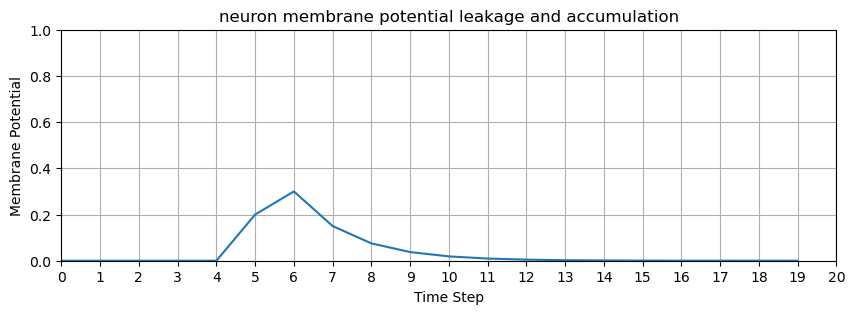

In [5]:
# set the time steps
time_steps = 20

# create a stimulus
stimulus = torch.zeros(time_steps)
stimulus[5] = torch.tensor(0.2)
stimulus[6] = torch.tensor(0.2)

# initialize the LIF neuron before using it
mem = lif.init_leaky()  # get the initialized membrane potential

# feed the stimulus into the neuron in a recurrent way
mem_record = []
for t in range(time_steps):
    spk_out, mem = lif(stimulus[t], mem)
    mem_record.append(mem)

mem_record = torch.stack(mem_record)
print_mem(mem_record.detach(), "neuron membrane potential leakage and accumulation")

At time step 5, the size of the input stimulus is 0.2, which is accumulated. So the membrane potential at time step 5 is 0.2. At time step 6, the neuron also receives a stimulus with a size of 0.2, which is accumulate, too. Due to the leakage feature of neurons, the potential at time step 5 leaks through the next time step at a decay rate of 0.5, so the final potential at time step 6 is (0.2 + 0.2*0.5)=0.3. In the next time steps, there is no more input stimulus. The membrane potential decays to 0 at the decay rate of 0.5. (We default 0 to be the resting potential.)

The decay rate of a neuron is determined when the neuron is initialized. We set it with `beta` parameter. Next is the comparison.


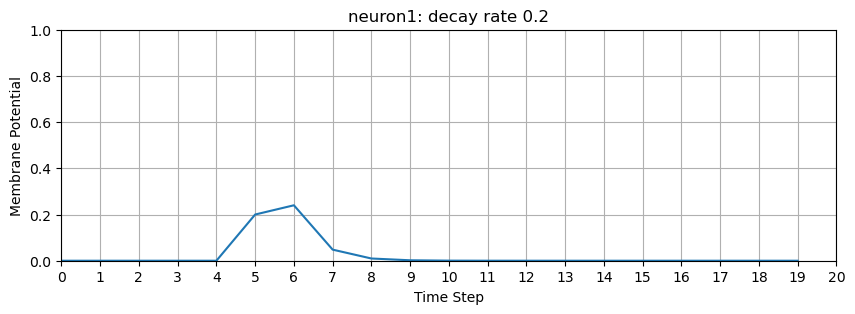

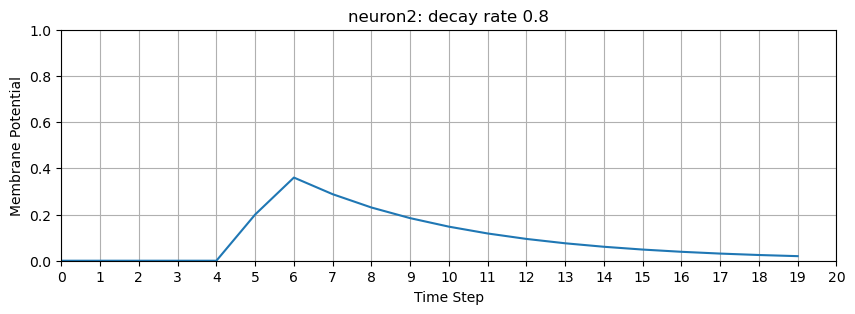

In [6]:
lif1 = snn.Leaky(beta=0.2)
lif2 = snn.Leaky(beta=0.8)

mem1 = lif1.init_leaky()
mem2 = lif2.init_leaky()

mem1_record = []
mem2_record = []
for t in range(time_steps):
    spk_out1, mem1 = lif1(stimulus[t], mem1)
    spk_out2, mem2 = lif2(stimulus[t], mem2)
    mem1_record.append(mem1)
    mem2_record.append(mem2)
mem1_record = torch.stack(mem1_record)
mem2_record = torch.stack(mem2_record)

print_mem(mem1_record.detach(), "neuron1: decay rate 0.2")
print_mem(mem2_record.detach(), "neuron2: decay rate 0.8")

As for now, our neurons have biodynamics of accumulation and leakage. How about the threshold excitation? We could use the parameter `threshold` to set the neuron's threshold in snnTorch. The default threshold is 1. An example of a threshold excitation process is like this.

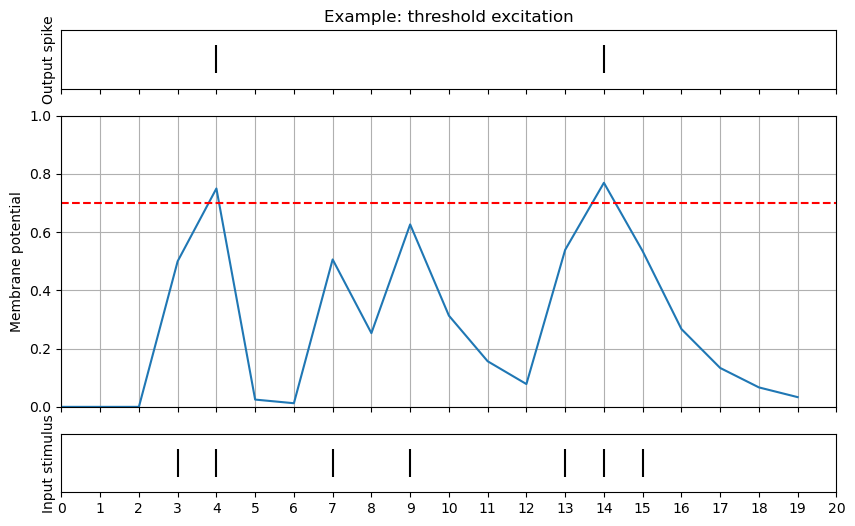

In [7]:
stimulus = torch.zeros(time_steps)
stimulus[3] = torch.tensor(0.5)
stimulus[4] = torch.tensor(0.5)
stimulus[7] = torch.tensor(0.5)
stimulus[9] = torch.tensor(0.5)
stimulus[13] = torch.tensor(0.5)
stimulus[14] = torch.tensor(0.5)
stimulus[15] = torch.tensor(0.5)

threshold = 0.7

lif = snn.Leaky(beta=0.5, threshold=threshold)
mem = lif.init_leaky()

mem_record = []
spk_record = []
for t in range(time_steps):
    spk_out, mem = lif(stimulus[t], mem)
    mem_record.append(mem)
    spk_record.append(spk_out)
mem_record = torch.stack(mem_record)
spk_record = torch.stack(spk_record)


print_spk_mem(
    mem_record.detach(),
    spk_record.detach(),
    stimulus,
    threshold,
    "Example: threshold excitation",
)

Could you analyze this result?

## A Simple Fully Connected SNN

We have successfully built a LIF neuron using snnTorch. Then, how to connect those neurons into a network and make the gradient propagate through it? We will adopt a fully connected network structure as an example to show how to construct an SNN.

At the beginning, we randomly generate a set of training data. It is worth noting that since snnTorch can use CUDA to calculate tensor, the format of the input data is usually `[time_steps, batch_size, _]`. We only generate a single event-based data in this example, and the data size is `[time_steps, 1]`, so we also need to encapsulate it into a batch form, that is, `[time_steps, 1, 1]`.

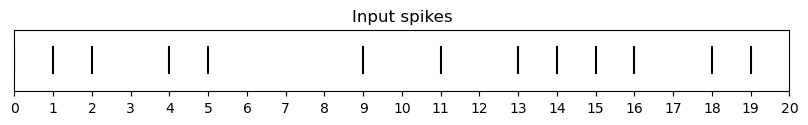

The output label: 8


In [8]:
input = torch.tensor([random.randint(0, 1) for _ in range(time_steps)])
label = torch.tensor(8)
print_spk(input, "Input spikes")
print(f"The output label: {label}")
input = input.unsqueeze(1).unsqueeze(1).float()

Then, we build the network structure. snnTorch is a Pytorch-based framework so that it can extend all essential functions of PyTorch. We use snntorch to build neurons for the biodynamics of SNNs. For the change of synaptic weights, we still use the interface of PyTorch.

We use the surrogate function instead of step functions as an activation mechanism for neurons. It is also determined when the neuron is initialized. In snnTorch, we could use `spike_grad` as the parameter to control the type of surrogate functions. In this example, we adopt the sigmoid function.

In [9]:
class snnFullyConnectedModel(nn.Module):
    def __init__(
        self, input_size, hidden_size, output_size, beta=0.8, time_steps=time_steps
    ):
        super().__init__()
        spike_grad = surrogate.fast_sigmoid(slope=25)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.time_steps = time_steps

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        mem2_record = []

        # deal with a data in the recurrent way
        for t in range(self.time_steps):
            current1 = self.fc1(x[t])
            spk1, mem1 = self.lif1(current1, mem1)
            current2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(current2, mem2)
            mem2_record.append(mem2)

        return torch.stack(mem2_record, dim=0)

Since the neuron's threshold is 1, in the network's last layer, we use the membrane potential instead of spikes as the output. For some specific scenarios (such as classification problems, ground truth is also in pulse form), directly using membrane potential as output can provide more convenience for backpropagation while achieving the same purpose.

In [10]:
model = snnFullyConnectedModel(1, 5, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
for _ in range(15):
    spk2 = model(input)
    result = torch.sum(spk2)
    loss = torch.abs(label - result)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(loss.item())

9.807443618774414
9.792760848999023
9.778074264526367
9.763383865356445
9.748701095581055
9.734016418457031
9.719329833984375
9.704647064208984
9.689958572387695
9.675273895263672
9.660589218139648
9.64590072631836
9.631216049194336
9.616531372070312
9.601846694946289


The training process is similar to traditional neural networks. snnTorch also supports the PyTorch optimizer. We can see that the loss is reduced during training. Since we only have one training data, the results don't have any real meaning. This is just a small demo based on the fully connected network structure. You will complete an SNN based on the CNN network structure in the practical assignment problem1 and use it to predict the angle variation of the double pendulum. Good luck with the following work!

Also, here are some useful tutorials from snnTorch:

https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_2.html

https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_3.html

https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_5.html